# Amazon Reviews For Sentiment Analysis

# TABLE OF CONTENTS 

* [Import Libraries](#0)
* [Read Data](#1)
* [Text Cleaning](#2)
* [Word Cloud](#3)
* [Tokeniztion & pad_sequences](#4)
* [Model](#5)
* [Model Check](#6)

# Import Libraries

In [3]:
import bz2
from tqdm import tqdm
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix,classification_report
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,SpatialDropout1D,Embedding
from keras.callbacks import ModelCheckpoint
import pickle

# Read Data

In [4]:
output_path='/kaggle/working/train.ft.txt'
with bz2.open('/kaggle/input/amazonreviews/train.ft.txt.bz2', 'rt', encoding='utf-8') as compressed_file, open(output_path, 'w', encoding='utf-8') as output_file:
    for line in compressed_file:
        output_file.write(line)
    print('Train Successful ❤')
output_path='/kaggle/working/test.ft.txt'
with bz2.open('/kaggle/input/amazonreviews/test.ft.txt.bz2', 'rt', encoding='utf-8') as compressed_file, open(output_path, 'w', encoding='utf-8') as output_file:
    for line in compressed_file:
        output_file.write(line)
    print('Test Successful ❤')

Train Successful ❤
Test Successful ❤


In [5]:
train,test,train_label,test_label=[],[],[],[]
with open('train.ft.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()
for line in tqdm(lines):
    train.append(line.split('__label__')[1][1:])
    train_label.append(line.split('__label__')[1][0])
with open('test.ft.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()
for line in tqdm(lines):
    test.append(line.split('__label__')[1][1:])
    test_label.append(line.split('__label__')[1][0])

100%|██████████| 400000/400000 [00:00<00:00, 761309.96it/s]


# Text Cleaning

In [6]:
def clean_text(text):
    # Remove non-alphanumeric characters and extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert multiple whitespace characters to a single space
    text = re.sub(r'\s+', ' ', text)
    # Convert the text to lowercase
    text = text.lower()
    return text

In [7]:
print('Train Length',len(train))
print('Train Label Length',len(train_label))
print('Test Length',len(test))
print('Test Label Length',len(test_label))

Train Length 3600000
Train Label Length 3600000
Test Length 400000
Test Label Length 400000


In [8]:
train_label[0],train[0]

('2',
 ' Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^\n')

In [9]:
train_label[0],clean_text(train[0])

('2',
 ' stuning even for the nongamer this sound track was beautiful it paints the senery in your mind so well i would recomend it even to people who hate vid game music i have played the game chrono cross but out of all of the games i have ever played it has the best music it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras it would impress anyone who cares to listen ')

In [10]:
test_label[0],test[0]

('2',
 ' Great CD: My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I\'m in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life\'s hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"\n')

In [11]:
test_label[0],clean_text(test[0])

('2',
 ' great cd my lovely pat has one of the great voices of her generation i have listened to this cd for years and i still love it when im in a good mood it makes me feel better a bad mood just evaporates like sugar in the rain this cd just oozes life vocals are jusat stuunning and lyrics just kill one of lifes hidden gems this is a desert isle cd in my book why she never made it big is just beyond me everytime i play this no matter black white young old male female everybody says one thing who was that singing ')

In [12]:
#train label
pd.DataFrame(train_label).value_counts()

1    1800000
2    1800000
dtype: int64

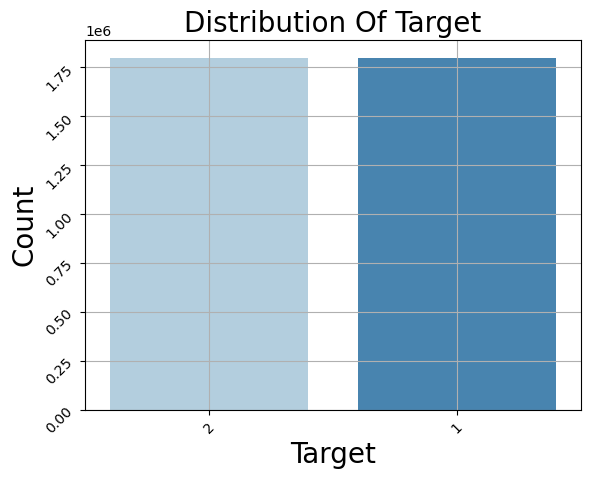

In [13]:
sns.countplot(x=pd.DataFrame(train_label)[0],palette='Blues')
plt.title('Distribution Of Target',fontsize=20)
plt.xlabel('Target',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [14]:
#test label
pd.DataFrame(test_label).value_counts()

1    200000
2    200000
dtype: int64

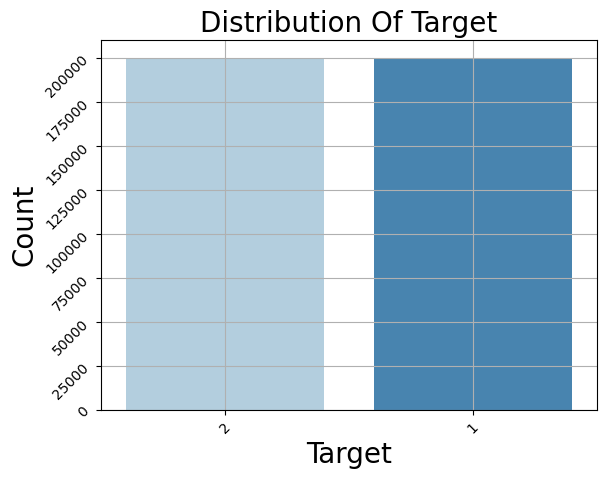

In [15]:
sns.countplot(x=pd.DataFrame(test_label)[0],palette='Blues')
plt.title('Distribution Of Target',fontsize=20)
plt.xlabel('Target',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [16]:
train=pd.DataFrame(train)[0].apply(clean_text)
test=pd.DataFrame(test)[0].apply(clean_text)
train.head()

0     stuning even for the nongamer this sound trac...
1     the best soundtrack ever to anything im readi...
2     amazing this soundtrack is my favorite music ...
3     excellent soundtrack i truly like this soundt...
4     remember pull your jaw off the floor after he...
Name: 0, dtype: object

In [17]:
test.head()

0     great cd my lovely pat has one of the great v...
1     one of the best game music soundtracks for a ...
2     batteries died within a year i bought this ch...
3     works fine but maha energy is better check ou...
4     great for the nonaudiophile reviewed quite a ...
Name: 0, dtype: object

# Word Cloud

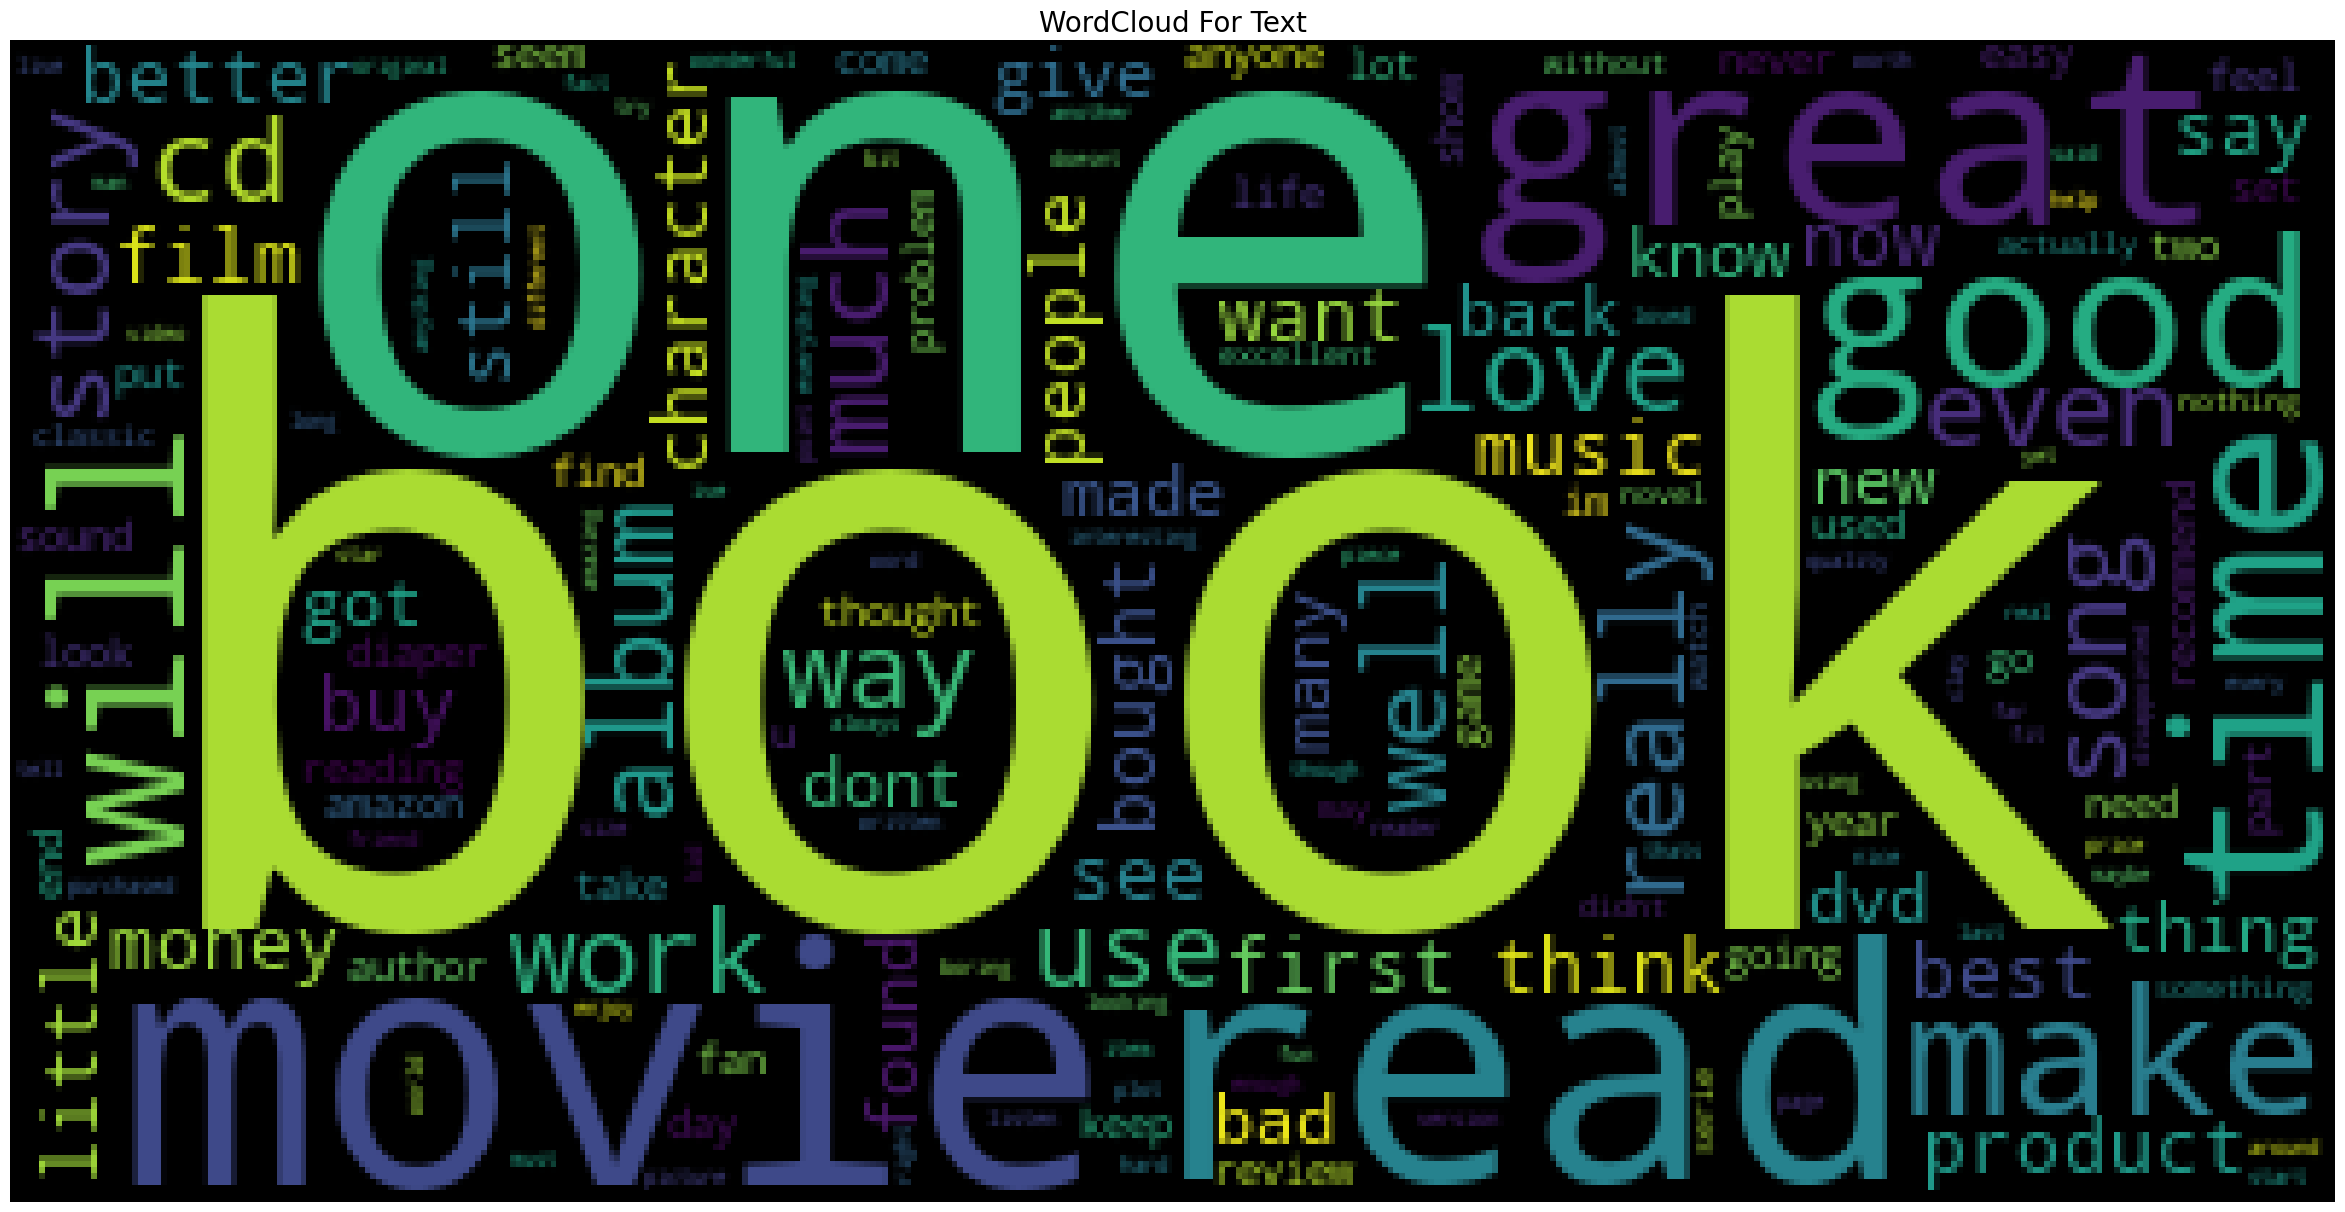

In [18]:
plt.figure(figsize=(30,20))
plt.imshow(WordCloud().generate(" ".join(train.iloc[:20000])))
plt.axis("off")
plt.title("WordCloud For Text",fontsize=20)
plt.show()

# Tokeniztion & pad_sequences

In [19]:
voc_size = 20000
max_length = 100
tokenizer = Tokenizer(num_words=voc_size)
tokenizer.fit_on_texts(train)
word_index = tokenizer.word_index
with open('/kaggle/working/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [20]:
train = tokenizer.texts_to_sequences(train)
train = pad_sequences(train, maxlen=max_length)
test = tokenizer.texts_to_sequences(test)
test = pad_sequences(test, maxlen=max_length)

In [21]:
train_lab=np.array([1 if i=='2' else 0 for i in train_label])
test_lab=np.array([1 if i=='2' else 0 for i in test_label])

# Model

In [22]:
model = Sequential()
model.add(Embedding(input_dim=voc_size, output_dim=64, input_length=max_length))
model.add(LSTM(units=32, return_sequences=True))
model.add(SpatialDropout1D(rate=0.2))  
model.add(LSTM(units=32))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           1280000   
                                                                 
 lstm (LSTM)                 (None, 100, 32)           12416     
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,300,769
Trainable params: 1,300,769
Non-trainable params: 0
______________________________________________

In [23]:
checkpoint_cb =ModelCheckpoint("amazon_model.h5", save_best_only=True)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(train, train_lab, epochs=2,
                    validation_split=.1,
                    callbacks=[checkpoint_cb])

Epoch 1/2
101250/101250 [==============================] - 1093s 11ms/step - loss: 0.1780 - accuracy: 0.9312 - val_loss: 0.1502 - val_accuracy: 0.9430
Epoch 2/2
101250/101250 [==============================] - 1005s 10ms/step - loss: 0.1449 - accuracy: 0.9458 - val_loss: 0.1466 - val_accuracy: 0.9447


In [24]:
loss,accuracy = model.evaluate(test, test_lab)
print("Loss:", loss)
print("Accuracy:", accuracy)

12500/12500 [==============================] - 58s 5ms/step - loss: 0.1493 - accuracy: 0.9435
Loss: 0.14927682280540466
Accuracy: 0.9434574842453003


In [25]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.178030,0.931153,0.150215,0.943025
1,0.144931,0.945809,0.146646,0.944733


In [26]:
prediction=model.predict(test)
y_pred=np.where(prediction>=.5,1,0)
df=pd.DataFrame()
df['actual'],df['pred']=test_lab,y_pred

12500/12500 [==============================] - 52s 4ms/step


In [28]:
df

,actual,pred
0,1,1
1,1,1
2,0,0
3,1,1
4,1,1
...,...,...
399995,0,0
399996,0,0
399997,0,0
399998,1,1


# Model Check

array([[187539,  12461],
       [ 10156, 189844]])

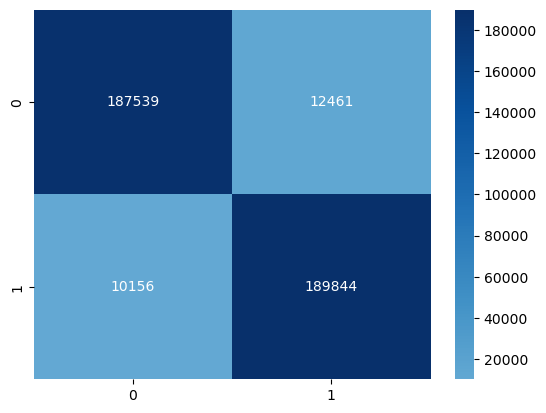

In [29]:
CM = confusion_matrix(test_lab, y_pred)
sns.heatmap(CM,annot=True,center = True,fmt='g',cmap='Blues')
CM

In [30]:
ClassificationReport = classification_report(test_lab,y_pred)
print('Classification Report is : ', ClassificationReport) 

Classification Report is :                precision    recall  f1-score   support

           0       0.95      0.94      0.94    200000
           1       0.94      0.95      0.94    200000

    accuracy                           0.94    400000
   macro avg       0.94      0.94      0.94    400000
weighted avg       0.94      0.94      0.94    400000



# Output

In [31]:
def prepare_text(text, tokenizer, max_length):
    text = clean_text(text)
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_length)
    return padded


In [32]:
custom_text = "I absolutely loved this product! It works flawlessly and exceeded my expectations."

processed_input = prepare_text(custom_text, tokenizer, max_length)

custom_pred = model.predict(processed_input)
label = "Positive (Label 2)" if custom_pred >= 0.5 else "Negative (Label 1)"


1/1 [==============================] - 1s 657ms/step


In [33]:

print("Custom Text:", custom_text)
print("Predicted Sentiment Score:", custom_pred[0][0])
print("Predicted Label:", label)


Custom Text: I absolutely loved this product! It works flawlessly and exceeded my expectations.
Predicted Sentiment Score: 0.9930999
Predicted Label: Positive (Label 2)


In [49]:
custom_text1 = " this product was terrible and broke after one use"

processed_input1 = prepare_text(custom_text1, tokenizer, max_length)

custom_pred1 = model.predict(processed_input1)

label1 = "Positive (Label 2)" if custom_pred1 >= 0.5 else "Negative (Label 1)"

1/1 [==============================] - 0s 23ms/step


In [50]:
print("Custom Text:", custom_text1)
print("Predicted Sentiment Score:", custom_pred1[0][0])
print("Predicted Label:", label1)


Custom Text:  this product was terrible and broke after one use
Predicted Sentiment Score: 0.004461502
Predicted Label: Negative (Label 1)


In [51]:
custom_text2 = " waste of money"

processed_input2 = prepare_text(custom_text2, tokenizer, max_length)

custom_pred2 = model.predict(processed_input2)

label2 = "Positive (Label 2)" if custom_pred2 >= 0.5 else "Negative (Label 1)"

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
1/1 [==============================] - 0s 24ms/step


In [52]:
print("Custom Text:", custom_text2)
print("Predicted Sentiment Score:", custom_pred2[0][0])
print("Predicted Label:", label2)


Custom Text:  waste of money
Predicted Sentiment Score: 0.015654337
Predicted Label: Negative (Label 1)


In [53]:
custom_text3 = " I want more same type"

processed_input3 = prepare_text(custom_text3, tokenizer, max_length)

custom_pred3 = model.predict(processed_input3)

label3 = "Positive (Label 2)" if custom_pred3 >= 0.5 else "Negative (Label 1)"

1/1 [==============================] - 0s 25ms/step


In [54]:
print("Custom Text:", custom_text3)
print("Predicted Sentiment Score:", custom_pred3[0][0])
print("Predicted Label:", label3)


Custom Text:  I want more same type
Predicted Sentiment Score: 0.5865282
Predicted Label: Positive (Label 2)
